In [1]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import scipy as sp
import pymaster as nmt
from tqdm import tqdm
import obs_cov
import mylib

In [7]:
nside = 128
lmax = 3*nside-1
npix = 12*nside**2
l = np.arange(lmax+1)
c2d = l*(l+1)/2/np.pi

In [8]:
mask, weight = mylib.get_weight(nside)
fsky = np.sum(mask)/npix
print(fsky*100)

apo_size = 10
mask_apo = nmt.mask_apodization(weight, apo_size, 'C2')

R_unapo = sp.sparse.load_npz(f'obsmat_nside{nside}/obsmat.npz')
R_QU_unapo = R_unapo[npix:, npix:]

Z = sp.sparse.diags_array(mask_apo)
ZZ = sp.sparse.block_diag([Z, Z, Z])
R = ZZ @ R_unapo
R_QU = R[npix:, npix:]

4.40673828125


In [ ]:
input_cls = mylib.get_camb(1, 0, lmax)
input_cls_noBB = np.copy(input_cls)
input_cls_noBB[2] = np.zeros(lmax+1)

In [8]:
Cl_EEonly = obs_cov.get_Cl(nside, 'E')
C_E = obs_cov.C_ana(nside, Cl_EEonly, None)

/scratch/yuyang/filterbin/obs_cov.py:12: RuntimeWarning: divide by zero encountered in divide
  C_l = 1/l**2
  0%|                                                                           | 0/768 [00:00<?, ?it/s]/scratch/yuyang/filterbin/obs_cov.py:57: RuntimeWarning: invalid value encountered in divide
  F = 2 * ( ((l+2)*z)/(1-z**2) * P_l2(l-1,z) - ((l-4)/(1-z**2) + l*(l-1)/2) * P_l2(l,z) ) / ((l-1)*l*(l+1)*(l+2))
/scratch/yuyang/filterbin/obs_cov.py:68: RuntimeWarning: invalid value encountered in divide
  F = 4 * ( (l+2)*P_l2(l-1,z) - (l-1)*z*P_l2(l,z) ) / ( (l-1)*l*(l+1)*(l+2)*(1-z**2) )
100%|█████████████████████████████████████████████████████████████████| 768/768 [11:03<00:00,  1.16it/s]


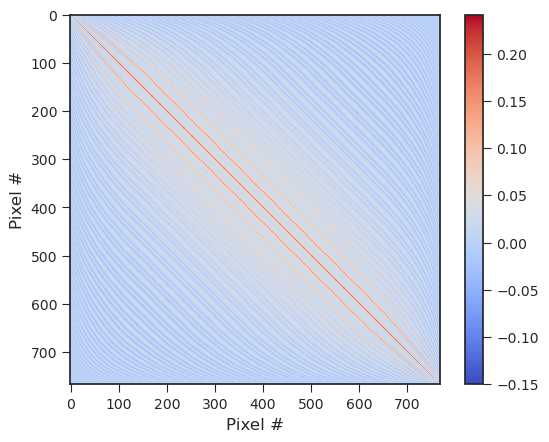

In [16]:
plt.style.use(['ggplot', 'seaborn-v0_8-ticks'])
plt.imshow(C_E[:npix, :npix], cmap='coolwarm')
plt.xlabel('Pixel #')
plt.ylabel('Pixel #')
plt.colorbar()

plt.savefig('plots/qq_cov.pdf', bbox_inches='tight')

In [2]:
nside = 8
npix = 12*nside**2
hits = hp.read_map(f'obsmat_nside{nside}/out/0/filterbin_hits.fits')
mask = np.zeros_like(hits)
mask[hits!=0]=1
fsky = np.sum(mask)/npix
print(fsky*100)

6.770833333333333


In [3]:
Cl_EEonly = obs_cov.get_Cl(nside, 'E')
Cl_BBonly = obs_cov.get_Cl(nside, 'B')

C_E = obs_cov.C_ana(nside, Cl_EEonly, mask)
C_B = obs_cov.C_ana(nside, Cl_BBonly, mask)

/scratch/yuyang/filterbin/obs_cov.py:12: RuntimeWarning: divide by zero encountered in divide
  C_l = 1/l**2
  0%|                                                                                                                                                                                  | 0/52 [00:00<?, ?it/s]/scratch/yuyang/filterbin/obs_cov.py:57: RuntimeWarning: invalid value encountered in divide
  F = 2 * ( ((l+2)*z)/(1-z**2) * P_l2(l-1,z) - ((l-4)/(1-z**2) + l*(l-1)/2) * P_l2(l,z) ) / ((l-1)*l*(l+1)*(l+2))
/scratch/yuyang/filterbin/obs_cov.py:68: RuntimeWarning: invalid value encountered in divide
  F = 4 * ( (l+2)*P_l2(l-1,z) - (l-1)*z*P_l2(l,z) ) / ( (l-1)*l*(l+1)*(l+2)*(1-z**2) )
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:03<00:00, 17.03it/s]


In [4]:
mask_apo = nmt.mask_apodization(mask, 10, 'C2')
R_unapo = sp.sparse.load_npz(f'obsmat_nside{nside}/obsmat.npz')
R_QU_unapo = R_unapo[npix:, npix:]

Z = sp.sparse.diags_array(mask_apo)
ZZ = sp.sparse.block_diag([Z, Z, Z])
R = ZZ @ R_unapo
R_QU = R[npix:, npix:]

In [5]:
obs_C_E = R_QU @ C_E @ R_QU.T
obs_C_B = R_QU @ C_B @ R_QU.T

In [6]:
diag_E = obs_C_E.diagonal()
diag_B = obs_C_B.diagonal()
sigma = (np.mean(diag_E[diag_E!=0]) + np.mean(diag_B[diag_B!=0])) / 2 /1000
factor = np.identity(obs_C_E.shape[0])*sigma**2

In [7]:
e, v = sp.sparse.linalg.eigs(obs_C_B+factor, 1536, obs_C_E+factor)

/tmp/ipykernel_569/1045144972.py:1: RuntimeWarning: k >= N - 1 for N * N square matrix. Attempting to use scipy.linalg.eig instead.
  e, v = sp.sparse.linalg.eigs(obs_C_B+factor, 1536, obs_C_E+factor)


In [8]:
eh, vh = sp.sparse.linalg.eigsh(obs_C_B+factor, 1536, obs_C_E+factor)

/tmp/ipykernel_569/2136243755.py:1: RuntimeWarning: k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.
  eh, vh = sp.sparse.linalg.eigsh(obs_C_B+factor, 1536, obs_C_E+factor)


In [9]:
order = np.argsort(e)

/scratch/yuyang/conda/envs/toast3/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/scratch/yuyang/conda/envs/toast3/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


[]

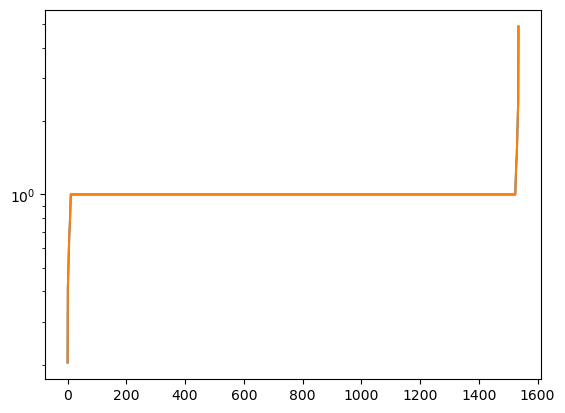

In [10]:
plt.plot(e[order])
plt.plot(eh)
plt.semilogy()

In [ ]:
mask_QU = np.concatenate([mask, mask])
zeros = np.where(mask_QU==0)[0]
for i in range(v.shape[1]):    
    v[:,i][zeros] = 0
    v[:,i] /= np.linalg.norm(pure_b[:,i], axis=0)

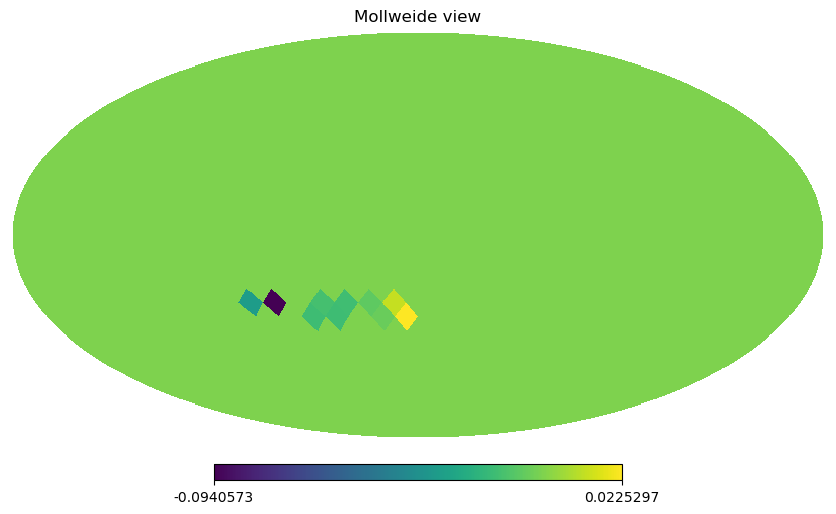

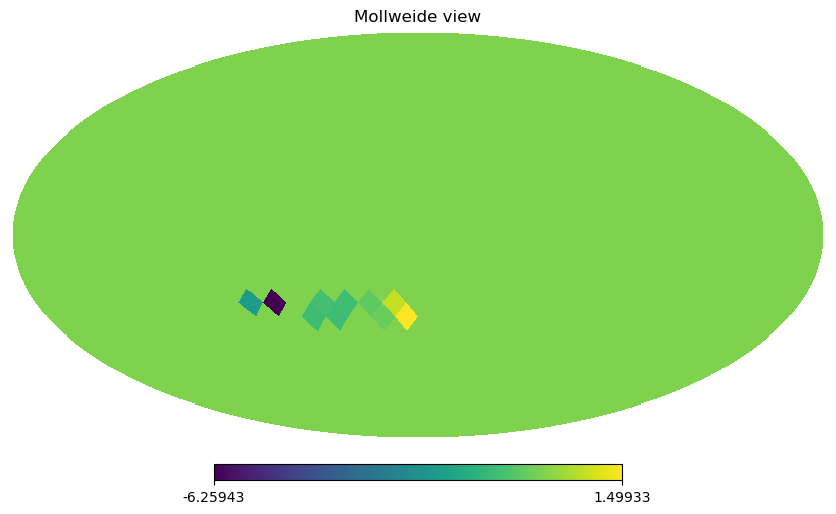

In [14]:
hp.mollview(v.T[order][-1].reshape(2,npix)[0])
hp.mollview(vh.T[-1].reshape(2,npix)[0])

In [4]:
# np.random.seed(0)
# m = (R @hp.synfast(input_cls_noBB, nside, new=True).flatten()).reshape(3, npix)
# # m = (R @hp.synfast(input_cls, nside, new=True).flatten()).reshape(3, npix)

In [5]:
# hp.mollview(hp.alm2map(hp.map2alm(m)[2], nside))

In [6]:
# bb = []
# pure_m = np.copy(m)
# for n_v in [1000, 2000, 3000, 4000, 5000]:
#     pi_b = sp.sparse.load_npz(f'apo{apo_size}/pi_b_{n_v}.npz')
#     pure_m[1:] = (pi_b @ m[1:].flatten()).reshape(2,npix)
#     hp.mollview(hp.alm2map(hp.map2alm(pure_m)[2], nside))
#     bb.append(hp.anafast(pure_m)[2])

In [7]:
# for i in range(5):
#     plt.plot(bb[i])
# plt.loglog()
# plt.xlim([20, 2*nside])

In [9]:
# nmc = 1024
# C_mc = np.zeros((2*npix, 2*npix))

# for i in range(nmc):
#     np.random.seed(i)
#     m = hp.synfast(Cl_EEonly, nside, new=True)    
#     m -= np.mean(m)
#     m_QU = np.concatenate([m[1], m[2]])
#     C_mc += np.outer(m_QU, m_QU)

# C_mc /= nmc

In [4]:
C_E = obs_cov.C_ana(nside, Cl_EEonly, mask)
C_B = obs_cov.C_ana(nside, Cl_BBonly, mask)

# sp.sparse.save_npz(f'C_E_{nside}', C_E)
# sp.sparse.save_npz(f'C_B_{nside}', C_B)

In [5]:
# C_E = sp.sparse.load_npz(f'C_E_{nside}.npz')
# C_B = sp.sparse.load_npz(f'C_B_{nside}.npz')

In [6]:
# obs_C_E = R_QU @ C_E @ R_QU.T
# obs_C_B = R_QU @ C_B @ R_QU.T

# sp.sparse.save_npz(f'obs_C_E_{nside}', obs_C_E)
# sp.sparse.save_npz(f'obs_C_B_{nside}', obs_C_B)

In [10]:
# obs_C_E = sp.sparse.load_npz(f'obs_C_E_{nside}.npz')
# obs_C_B = sp.sparse.load_npz(f'obs_C_B_{nside}.npz')

In [11]:
# # sparse
# diag_E = obs_C_E.diagonal()
# diag_B = obs_C_B.diagonal()

# sigma = (np.mean(diag_E[diag_E!=0]) + np.mean(diag_B[diag_B!=0])) / 2 /1000
# factor = sp.sparse.identity(obs_C_E.shape[0])*sigma**2

In [12]:
# %%time
# eigs, v = sp.sparse.linalg.eigsh( obs_C_B+factor, 2000, obs_C_E+factor)

CPU times: user 1h 53min 55s, sys: 5min 5s, total: 1h 59min 1s
Wall time: 30min 29s


In [13]:
# from sksparse.cholmod import cholesky
# cho = cholesky(obs_C_E+factor)

/tmp/ipykernel_13826/1696636031.py:2: CholmodTypeConversionWarning: converting matrix of class csr_array to CSC format
  cho = cholesky(obs_C_E+factor)
/tmp/ipykernel_13826/1696636031.py:2: CholmodTypeConversionWarning: converting matrix of class csc_array to CSC format
  cho = cholesky(obs_C_E+factor)


In [14]:
# %%time
# Minv = sp.sparse.linalg.LinearOperator(matvec=lambda b: cho(b), shape=obs_C_E.shape, dtype=obs_C_E.dtype)
# eigs1, v1 = sp.sparse.linalg.eigsh( obs_C_B+factor, 1900, obs_C_E+factor, Minv=Minv)

In [17]:
# %%time
# M = sp.sparse.linalg.LinearOperator(matvec=lambda b: cho(b), shape=obs_C_E.shape, dtype=obs_C_E.dtype)
# Minv = sp.sparse.linalg.LinearOperator(matvec=lambda b: sp.sparse.linalg.cg(obs_C_E + factor, b, M=M)[0], shape=obs_C_E.shape, dtype=obs_C_E.dtype)
# eigs3, v3 = sp.sparse.linalg.eigsh( obs_C_B+factor, 2000, obs_C_E+factor, Minv=Minv)

In [7]:
prefix = 'apo10'
eigs10 = np.load(f'{prefix}/eigenvalues.npy')
v = np.load(f'{prefix}/eigenvectors.npy')

In [6]:
# prefix = 'apo2'
# eigs2 = np.load(f'{prefix}/eigenvalues.npy')
# # v = np.load(f'{prefix}/eigenvectors.npy')

In [7]:
# prefix = 'apo8'
# eigs8 = np.load(f'{prefix}/eigenvalues.npy')

505.2887271679491


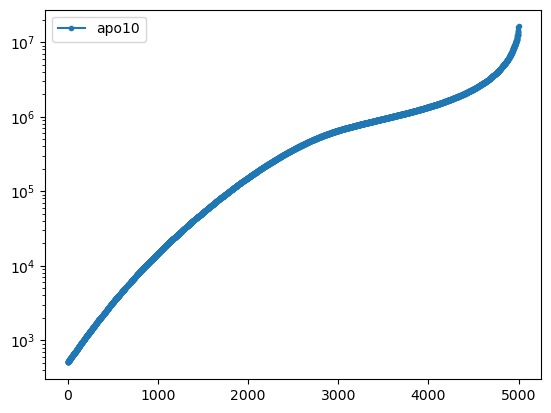

In [8]:
# plt.plot(eigs2[-3000:], marker='.')
plt.plot(eigs10, marker='.', label='apo10')
# plt.plot(eigs8[-3000:], marker='.', label='apo8')
# # plt.plot(eigs2, marker='.')
# plt.plot(eigs3, marker='.')
plt.semilogy()
plt.legend()
print(eigs10[0])

In [10]:
# purification
cut = 1.02
pass_cut = np.where(eigs10 >= cut)[0]

In [11]:
pure_b = v[:, pass_cut]
pure_b.shape

(393216, 5000)

In [12]:
pure_b[:,0] @ pure_b[:,-1]

-39.78512945049533

In [13]:
mask_QU = np.concatenate([mask, mask])
zeros = np.where(mask_QU==0)[0]

In [14]:
for i in range(pure_b.shape[1]):    
    pure_b[:,i][zeros] = 0
    pure_b[:,i] /= np.linalg.norm(pure_b[:,i], axis=0)

In [15]:
pure_b[:,0] @ pure_b[:,-1]

-0.0003812577281531288

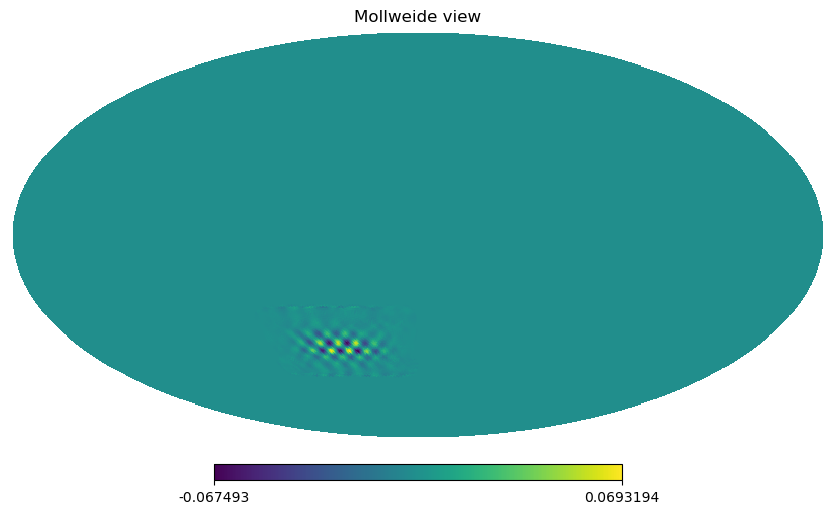

In [16]:
hp.mollview(pure_b[:,-1].reshape(2, npix)[0])

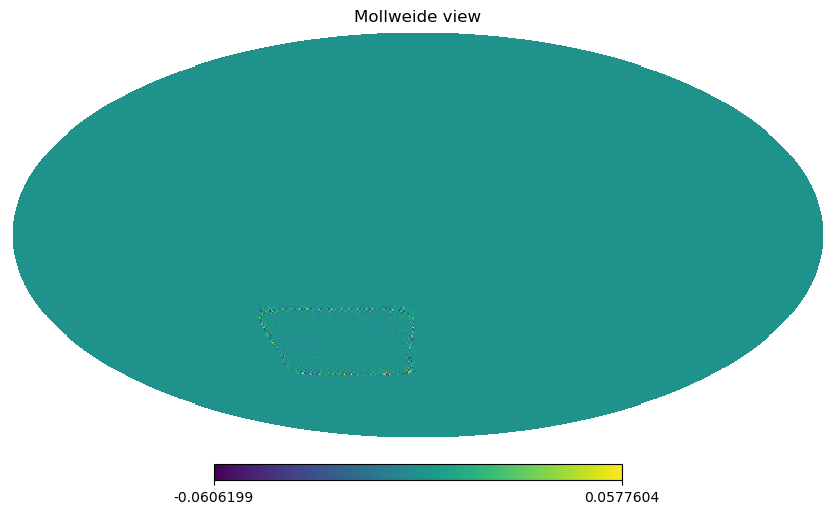

In [17]:
hp.mollview(pure_b[:,0].reshape(2, npix)[0])

In [35]:
#Sparse
pure_b = sp.sparse.csr_array(pure_b)
pure_b

<393216x7000 sparse array of type '<class 'numpy.float64'>'
	with 121296000 stored elements in Compressed Sparse Row format>

In [ ]:
pi_b = pure_b @ sp.sparse.linalg.inv(pure_b.T @ pure_b) @ pure_b.T
# pi_b = pure_b @ pure_b.T
pi_b

In [37]:
# sp.sparse.linalg.eigsh(pi_b, 3, return_eigenvectors=False)

In [38]:
#dense
# pi_b = pure_b @ pure_b.T
# pi_b = pure_b @ np.linalg.inv(pure_b.T @ pure_b) @ pure_b.T
# e,_ = sp.linalg.eigh(pi_b)
# e

In [ ]:
sp.sparse.save_npz(f'pi_b_{nside}', pi_b)